In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from os.path import join
# import config
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import analyze_helper
import viz
from neuro.features.feat_select import get_alphas

In [2]:
results_dir = analyze_helper.best_results_dir
r, cols_varied, mets = analyze_helper.load_clean_results(results_dir)

100%|██████████| 863/863 [04:37<00:00,  3.11it/s]


experiment varied these params: ['subject', 'num_stories', 'feature_space', 'embedding_layer', 'feature_selection_alpha', 'feature_selection_stability_seeds', 'qa_embedding_model', 'qa_questions_version', 'ndelays']


In [7]:
r = r[r.qa_questions_version.isin(['', 'v3_boostexamples'])]
# r = r[r.feature_selection_alpha == -1]
r = r[~r.feature_space.isin(
    ['meta-llama/Llama-2-7b-hf', 'meta-llama/Meta-Llama-3-8B'])]
cols_varied = [c for c in cols_varied if not c in [
    'feature_selection_stability_seeds']]

r = r[r.qa_embedding_model.isin(['', 'ensemble1'])]

# only keep feature selection with stability
r = r[(r.feature_selection_alpha < 0) | (
    r.feature_selection_stability_seeds > 0)]

r.shape

(746, 59)

### Check runs (full grid)

In [11]:
d = r
# d = d[d.subject.isin(['S01', 'S02', 'S03'])]
d = d[d.feature_selection_alpha < 0]
d = d.groupby(cols_varied)[['corrs_test_mean']].mean()
cols_top = ['feature_space', 'embedding_layer',
            'qa_embedding_model', 'qa_questions_version', 'feature_selection_alpha']
d = (
    d.pivot_table(index=[c for c in cols_varied if not c in cols_top],
                  columns=cols_top, values='corrs_test_mean', aggfunc='mean')
    .sort_index(axis=1)
)
display(
    d.style
    .background_gradient(cmap='magma', axis=1)
    .format(precision=3)

)

## Check simplified table

/tmp/ipykernel_4020140/3031422253.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['All' if label.get_text() ==


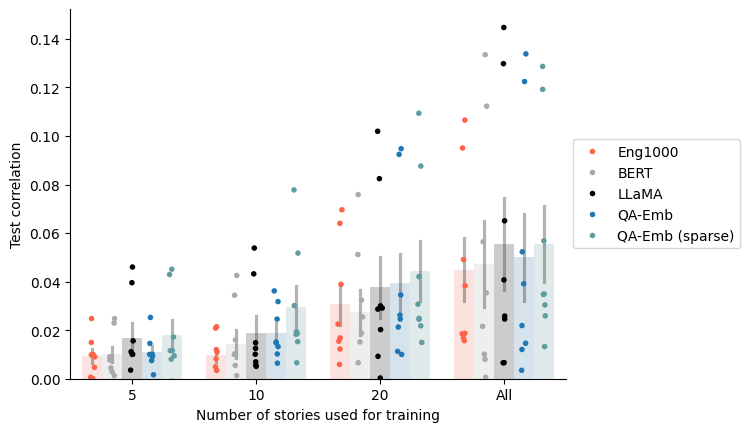

In [9]:
d = r
d.num_stories = d.num_stories.replace(-1, 100)
num_stories_list = [5, 10, 20, 100]
d = d[d.num_stories.isin(num_stories_list)]
# d = d[d.num_stories == 10]
# d = d[d.subject.isin(['S01', 'S02', 'S03'])]
# d = d[~d.subject.isin(['S01', 'S02', 'S03'])]
d = d[
    (d.feature_selection_alpha < 0) |
    ((d.feature_space_simplified == 'qa_embedder')
     & (d.feature_selection_alpha == get_alphas('qa_embedder')[3]))
]
group_cols = ['subject', 'num_stories',
              'feature_space_simplified', 'feature_selection_alpha']
metric_sort = 'corrs_tune_pc_weighted_mean'
d = d.sort_values(
    by=metric_sort, ascending=False)

d = d.groupby(group_cols)[mets]
d = d.first().reset_index()
cols_top = ['feature_space_simplified', 'feature_selection_alpha']
d_tab = (
    d.pivot_table(index=[c for c in group_cols if not c in cols_top],
                  columns=cols_top, values='corrs_test_mean', aggfunc='mean')
    .sort_index(axis=1)
)
display(
    d_tab.style
    .background_gradient(cmap='magma', axis=1)
    .format(precision=3)
)


# plot
d['legend'] = list(
    zip(d.feature_space_simplified.map(viz.feature_space_rename), d.feature_selection_alpha))
# ('BERT', -1.0), ('Eng1000', -1.0), ('LLaMA', -1.0),
#    ('QA-Emb', -1.0), ('QA-Emb', 0.28)
d['legend'] = d['legend'].map(lambda x: {
    ('BERT', -1.0): 'BERT',
    ('Eng1000', -1.0): 'Eng1000',
    ('LLaMA', -1.0): 'LLaMA',
    ('QA-Emb', -1.0): 'QA-Emb',
    ('QA-Emb', 0.28): 'QA-Emb (sparse)'
}.get(x, x))
kwargs = dict(
    data=d,
    x='num_stories',
    y='corrs_test_mean',
    hue='legend',
    hue_order=['Eng1000', 'BERT', 'LLaMA', 'QA-Emb', 'QA-Emb (sparse)'],
    palette=['tomato', '#aaa', '#000', 'C0', 'cadetblue'],
    dodge=True,
)
# sns.boxplot(**kwargs, fill=False)
# fig = plt.figure(figsize=(12, 6))
ax = sns.barplot(**kwargs, alpha=0.2, errorbar='se',
                 err_kws={'alpha': 0.4}, legend=False)
sns.stripplot(**kwargs, jitter=True, size=4)

# ylim bottom to 0
plt.ylim(bottom=0)

# replace "100" with "All" on xticklabels
xtick_labels = ax.get_xticklabels()
ax.set_xticklabels(['All' if label.get_text() ==
                   '100' else label.get_text() for label in xtick_labels])

plt.xlabel("Number of stories used for training")
plt.ylabel("Test correlation")
# put legend to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
num_stories_list = [5, 10, 20, 100]
dt = d_tab.reset_index()
for i, num_stories in enumerate(num_stories_list):
    dn = dt[dt.num_stories == num_stories]
    # display(dn)
    print(f'num_stories = {num_stories}')
    display(dn.drop(columns=['num_stories']).style.background_gradient(
        cmap='magma', axis=1).format(precision=3))

num_stories = 5


/tmp/ipykernel_4020140/1032307835.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  display(dn.drop(columns=['num_stories']).style.background_gradient(


num_stories = 10


/tmp/ipykernel_4020140/1032307835.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  display(dn.drop(columns=['num_stories']).style.background_gradient(


num_stories = 20


/tmp/ipykernel_4020140/1032307835.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  display(dn.drop(columns=['num_stories']).style.background_gradient(


num_stories = 100


/tmp/ipykernel_4020140/1032307835.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  display(dn.drop(columns=['num_stories']).style.background_gradient(
